In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


In [7]:
data = pd.read_csv('WAG_C_M.csv', engine = 'python', sep = ';', index_col=['month'], parse_dates=['month'], dayfirst=True)

In [8]:
data

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5
...,...
2016-04-01,36497.0
2016-05-01,37270.0
2016-06-01,38447.0


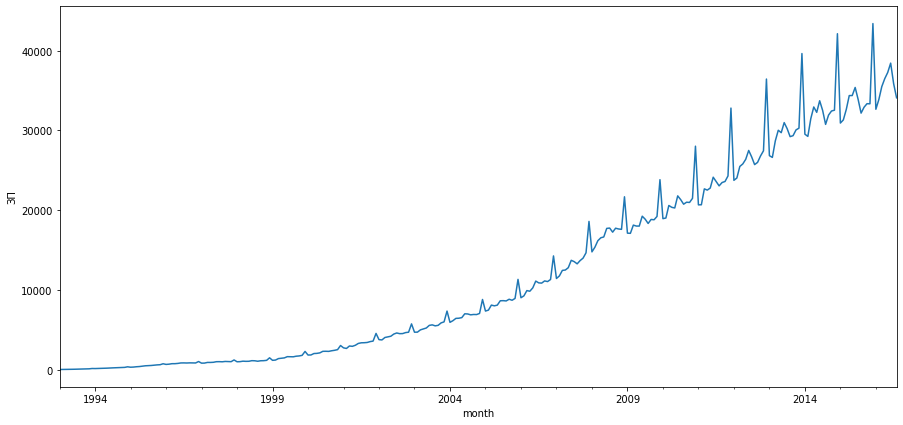

In [9]:
plt.figure(figsize(15,7))
data.WAG_C_M.plot()
plt.ylabel('ЗП')
pylab.show()

Критерий Дики-Фуллера: p=0.991850


<Figure size 1080x720 with 0 Axes>

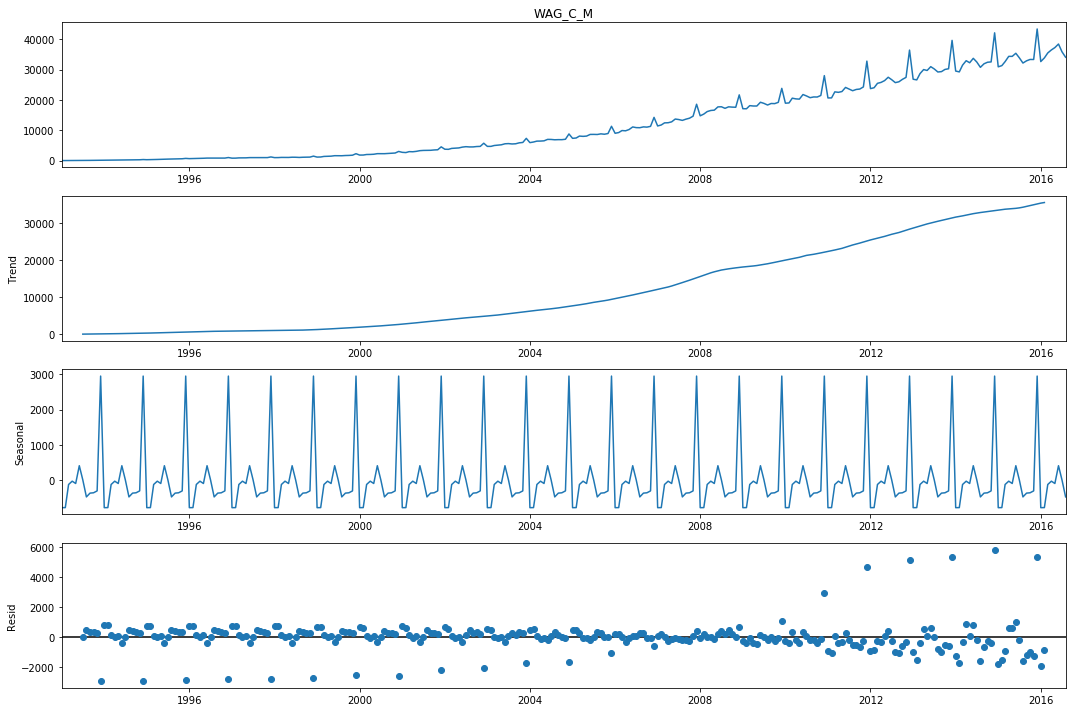

In [10]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.WAG_C_M).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M)[1])

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


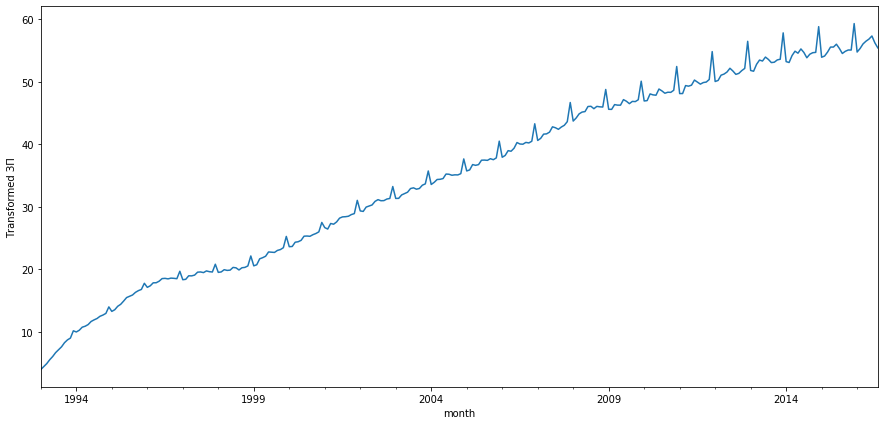

In [11]:
# очевидно, требуется стабилизация дисперсии, так как пики постепенно увеличиваются относительно бекгрануда

data['Box'], lmbda = stats.boxcox(data.WAG_C_M)
plt.figure(figsize(15,7))
data.Box.plot()
plt.ylabel(u'Transformed ЗП')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.Box)[1])

Критерий Дики-Фуллера: p=0.014697


<Figure size 1080x720 with 0 Axes>

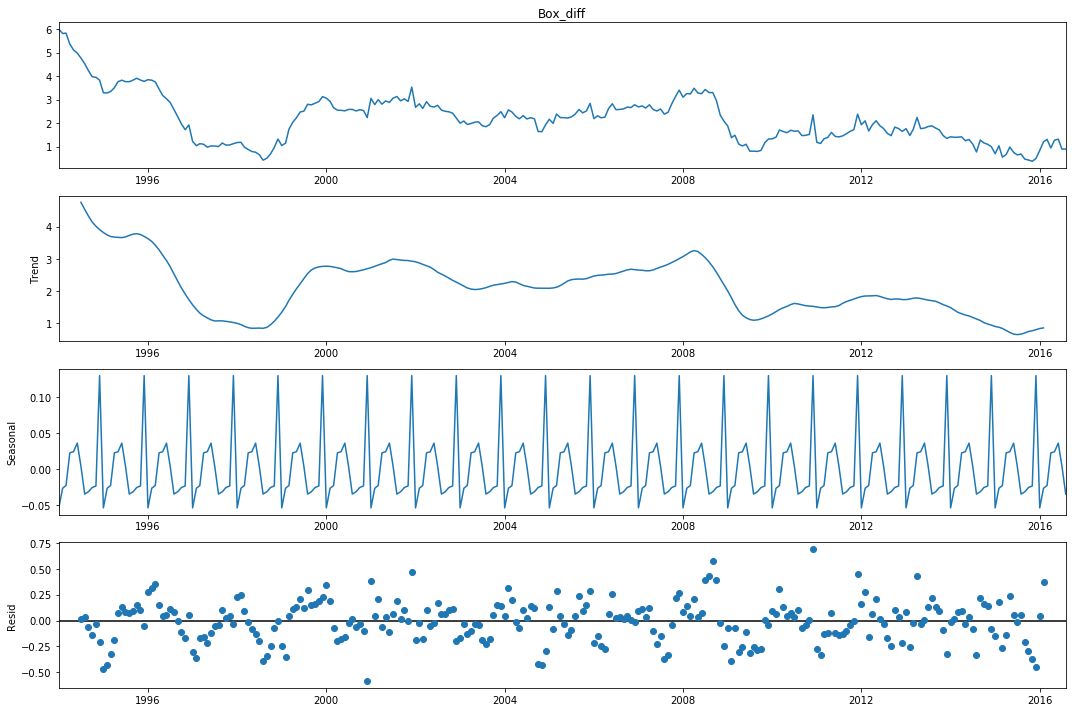

In [12]:
# делаем сезонное дифференцирование 
data['Box_diff'] = data.Box - data.Box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.Box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.Box_diff[12:])[1])

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

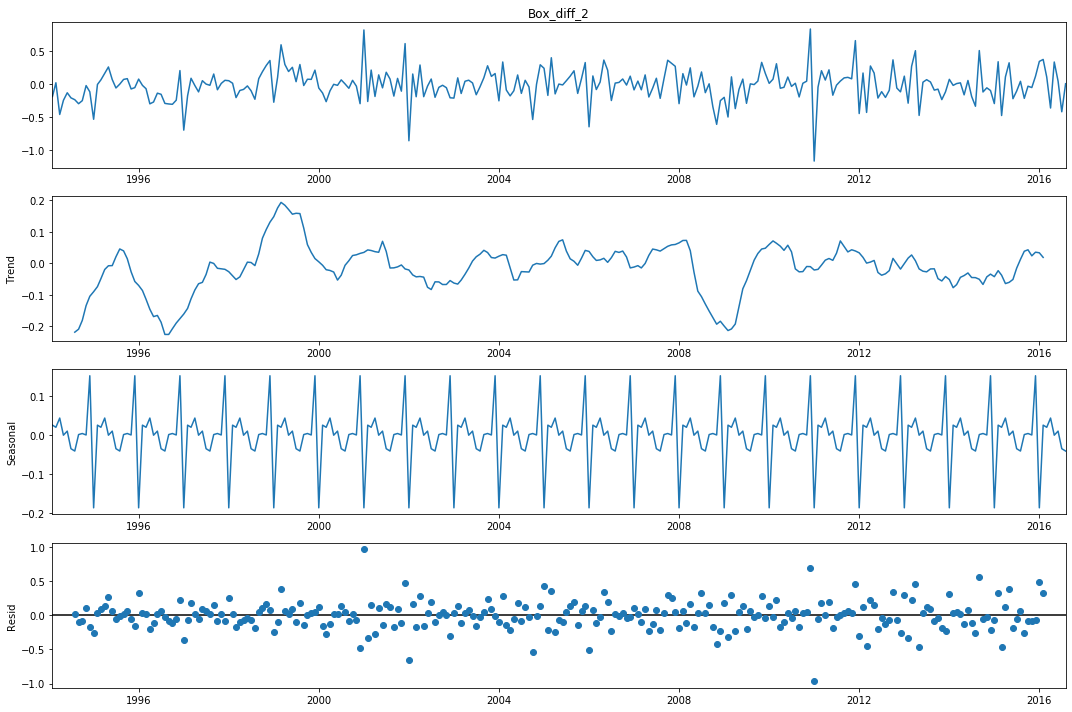

In [13]:
# в последнем разбиении тренд еще остался, а также наблюдается нестационарность. Продифференцируем по-обычному
data['Box_diff_2'] = data.Box_diff - data.Box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.Box_diff_2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.Box_diff_2[13:])[1])

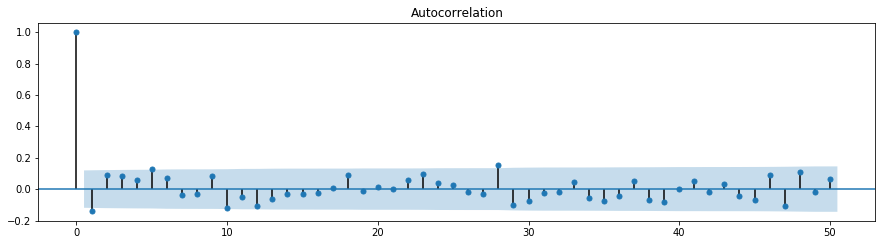

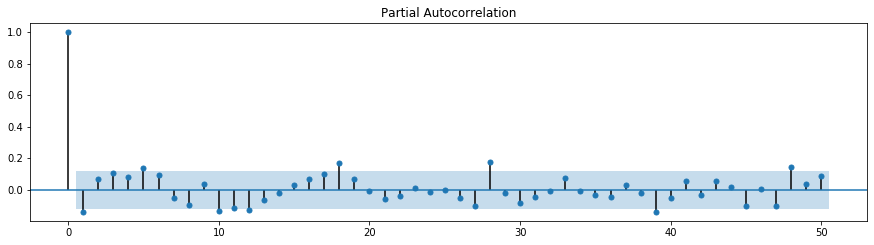

In [14]:
# теперь все вроде как ок, строим автокорреляции
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.Box_diff_2[13:].values.squeeze(), lags=50, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.Box_diff_2[13:].values.squeeze(), lags=50, ax=ax)
pylab.show()

In [23]:
# теперь выискиваем параметры модели
ps = range(0, 2)
d=1
qs = range(0, 2)
Ps = range(0, 2)
D=1
Qs = range(0, 1)

In [24]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

8

In [25]:
parameters

In [26]:
# делаем собственно модель

%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.Box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 1.17 s


In [27]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

     parameters       aic
5  (1, 0, 1, 0)  0.340521
3  (0, 1, 1, 0)  1.170768
7  (1, 1, 1, 0)  2.021911
4  (1, 0, 0, 0)  2.625709
2  (0, 1, 0, 0)  3.369832


In [28]:
# а вот и модель по лучшим параметрам (если думать, что я их реально нашел, хе-хе)

print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                Box   No. Observations:                  284
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                   2.830
Date:                            Sun, 26 Apr 2020   AIC                              0.341
Time:                                    14:16:58   BIC                             11.147
Sample:                                01-01-1993   HQIC                             4.679
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1488      0.046     -3.210      0.001      -0.240      -0.058
ar.S.L12      -0.1314      0.046   

Критерий Стьюдента: p=0.090798
Критерий Дики-Фуллера: p=0.000003


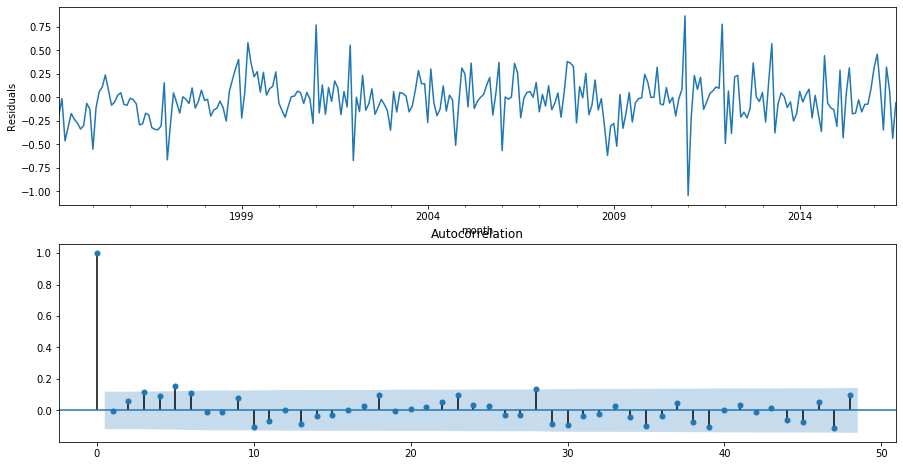

In [29]:
# смотрим остатки
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

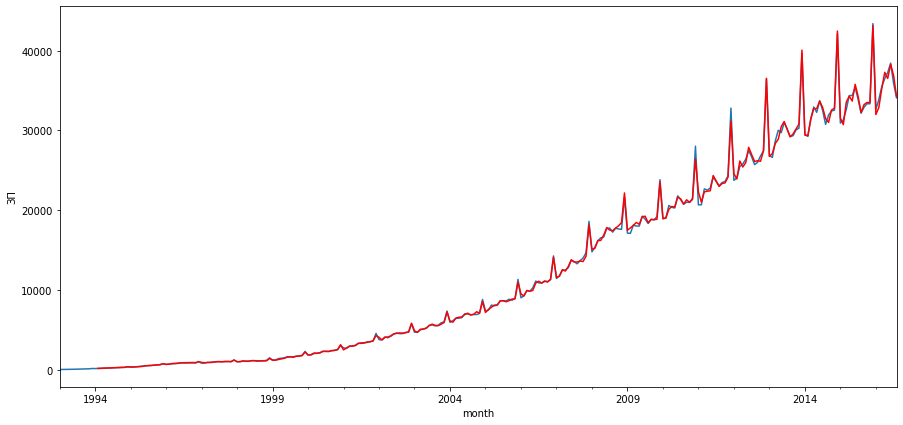

In [31]:
# критерий Стьюдента не сильно выше чем 0.05, но тренда я не вижу. Допустим все ок. Смотрим, как модель фиттит данные
data['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
data.WAG_C_M.plot()
data.model[13:].plot(color='r')
plt.ylabel('ЗП')
pylab.show()

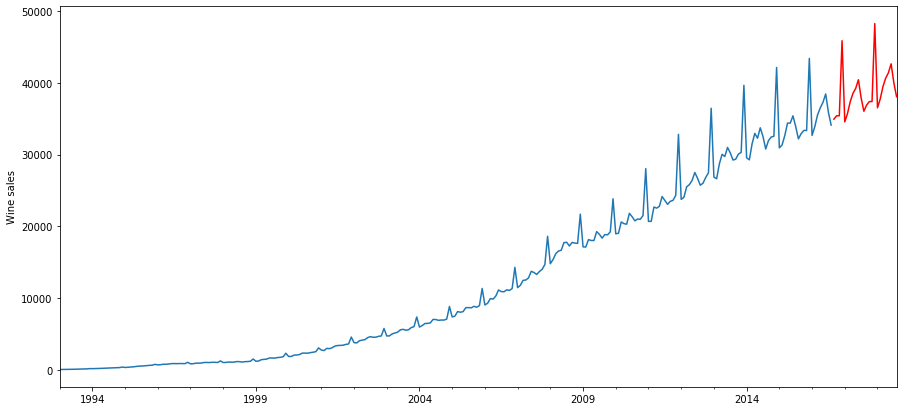

In [33]:
# Строим предсказание на пару лет
data1 = data[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= data1.columns)
data1 = pd.concat([data1, future])
data1['forecast'] = invboxcox(best_model.predict(start=284, end=308), lmbda)

plt.figure(figsize(15,7))
data1.WAG_C_M.plot()
data1.forecast.plot(color='r')
plt.ylabel('Wine sales')
pylab.show()